# Introduction

*TODO: run and solve other todos*

TP53, known as the Guardian of the Genome, is the most commonly mutated gene in human cancers. Understanding its regulation is critical. In the "A machine learning and directed network optimization approach to uncover TP53 regulatory patterns" two strategies were used to explore this: machine learning to predict TP53 mutation status from transcriptomic data, and directed regulatory networks to analyze the impact of these mutations on TP53 target gene expression.

In this notebook we provide our own solution to the first of the two problems, trying to understand the mutation type of a certain cell, as well as if a certain mutation compromises the functionality of the cell itself.

# Exploratory Data Analysis

Data comes from the The Cancer Genome Atlas Program and contains different cancer cells where TP53 is mutated. The data contains information about the type of mutation (missense or others) and wheter the cell was compromised.

In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn


Matplotlib is building the font cache; this may take a moment.


In [3]:
csv_file = 'data/TCGA_labels.csv'
df = pd.read_csv(csv_file)
df.head()

Variant_Classification  ABCB9..ENSG00023457  \
0  A129Vfs*20_TCGA-66-2785_Frame_Shift_Ins_17:g.7...           376.831000   
1  A138_P142del_TCGA-25-2393_In_Frame_Del_17:g.75...           198.244448   
2  A138Cfs*27_TCGA-55-6980_Frame_Shift_Del_17:g.7...           117.516000   
3  A138Cfs*27_TCGA-55-6980_Frame_Shift_Del_17:g.7...            60.747000   
4  A138Cfs*27_TCGA-D8-A13Y_Frame_Shift_Del_17:g.7...           327.477000   

   ABLIM1..ENSG0003983  ACTA2..ENSG00059  ACTB..ENSG00060  \
0           1358.86000       2471.580000     143602.00000   
1           5367.62179       2528.570328      77726.97678   
2           1936.34000      14533.700000     185841.00000   
3           5667.60000       3560.420000     107645.00000   
4           1096.61000       3430.480000      64166.60000   

   ADORA2B..ENSG000136  ADRB2..ENSG000154  AEBP2..ENSG000121536  \
0           159.674000          63.136500            946.639000   
1            19.656121           2.579692           2130.976296   
2            95.490700         191.866000            766.578000   
3            86.834700        1047.620000            698.413000   
4            51.837300           9.491300            706.010000   

   AEN..ENSG00064782  AGAP1..ENSG000116987  ...  ZCCHC2..ENSG00054877  \
0         626.477000            344.195000  ...            323.344000   
1         732.991931            386.605718  ...            228.638412   
2         256.410000            239.611000  ...            230.672000   
3         186.741000            262.372000  ...            638.609000   
4        1617.540000            821.366000  ...            806.811000   

   ZDHHC14..ENSG00079683  ZFP36L1..ENSG000677  ZMAT3..ENSG00064393  \
0              75.356400          8558.040000            43.991900   
1             322.247574          6446.509718            36.542642   
2             121.132000         12726.800000            74.270600   
3             343.604000          8024.280000            78.431400   
4             124.118000          1350.690000           237.649000   

   ZMIZ1..ENSG00057178  ZMIZ2..ENSG00083637  ZMYND8..ENSG00023613  \
0          1783.300000          5320.570000           1018.330000   
1          3207.438557          3213.116903           1688.261865   
2          2496.910000          4005.300000            923.961000   
3          3746.030000          2692.810000           1168.070000   
4          1885.860000          2283.400000           1967.630000   

   ZNF561..ENSG00093134  is_true         mutation  
0            821.181000     True  Frame_Shift_Ins  
1           1149.407697     True     In_Frame_Del  
2            391.689000     True  Frame_Shift_Del  
3            670.402000     True  Frame_Shift_Del  
4            480.043000     True  Frame_Shift_Del  

[5 rows x 554 columns]

## Basic Exploration

In [4]:
import sklearn
from sklearn.decomposition import PCA

In [5]:
df_full = df
df = df.drop(columns=['is_true', 'mutation', 'Variant_Classification'])

In [6]:
df.head()

ABCB9..ENSG00023457  ABLIM1..ENSG0003983  ACTA2..ENSG00059  \
0           376.831000           1358.86000       2471.580000   
1           198.244448           5367.62179       2528.570328   
2           117.516000           1936.34000      14533.700000   
3            60.747000           5667.60000       3560.420000   
4           327.477000           1096.61000       3430.480000   

   ACTB..ENSG00060  ADORA2B..ENSG000136  ADRB2..ENSG000154  \
0     143602.00000           159.674000          63.136500   
1      77726.97678            19.656121           2.579692   
2     185841.00000            95.490700         191.866000   
3     107645.00000            86.834700        1047.620000   
4      64166.60000            51.837300           9.491300   

   AEBP2..ENSG000121536  AEN..ENSG00064782  AGAP1..ENSG000116987  \
0            946.639000         626.477000            344.195000   
1           2130.976296         732.991931            386.605718   
2            766.578000         256.410000            239.611000   
3            698.413000         186.741000            262.372000   
4            706.010000        1617.540000            821.366000   

   AHDC1..ENSG00027245  ...  ZBTB38..ENSG000253461  ZBTB7C..ENSG000201501  \
0           435.438000  ...             1820.37000             264.358000   
1          1185.830576  ...              527.55836              16.858995   
2          1976.130000  ...             1439.43000             164.456000   
3           738.562000  ...             2136.32000             414.566000   
4          1041.860000  ...             1168.53000             183.986000   

   ZCCHC2..ENSG00054877  ZDHHC14..ENSG00079683  ZFP36L1..ENSG000677  \
0            323.344000              75.356400          8558.040000   
1            228.638412             322.247574          6446.509718   
2            230.672000             121.132000         12726.800000   
3            638.609000             343.604000          8024.280000   
4            806.811000             124.118000          1350.690000   

   ZMAT3..ENSG00064393  ZMIZ1..ENSG00057178  ZMIZ2..ENSG00083637  \
0            43.991900          1783.300000          5320.570000   
1            36.542642          3207.438557          3213.116903   
2            74.270600          2496.910000          4005.300000   
3            78.431400          3746.030000          2692.810000   
4           237.649000          1885.860000          2283.400000   

   ZMYND8..ENSG00023613  ZNF561..ENSG00093134  
0           1018.330000            821.181000  
1           1688.261865           1149.407697  
2            923.961000            391.689000  
3           1168.070000            670.402000  
4           1967.630000            480.043000  

[5 rows x 551 columns]

In [7]:
df.describe()

ABCB9..ENSG00023457  ABLIM1..ENSG0003983  ACTA2..ENSG00059  \
count          4211.000000          4211.000000       4211.000000   
mean            185.589301          3954.889567       7200.974864   
std             148.231968          3147.431047      17236.982170   
min               8.051500            29.764800         30.048173   
25%             103.270500          1815.710000       1221.666028   
50%             151.606000          3167.505717       2886.380000   
75%             224.627000          5211.564607       6516.566190   
max            3918.930000         34507.870810     252607.000000   

       ACTB..ENSG00060  ADORA2B..ENSG000136  ADRB2..ENSG000154  \
count      4211.000000          4211.000000        4211.000000   
mean     114439.524334           207.436478         147.286450   
std       48604.774763           241.214042         262.220737   
min       24218.900000             0.000000          -0.210767   
25%       79320.416245            39.071550          15.592600   
50%      105861.297800           123.480903          48.509415   
75%      139285.500000           298.676000         154.258000   
max      478521.000000          3115.940000        4181.060000   

       AEBP2..ENSG000121536  AEN..ENSG00064782  AGAP1..ENSG000116987  \
count           4211.000000        4211.000000           4211.000000   
mean             825.070216         592.848118            442.641521   
std              560.475285         350.756481            239.295632   
min               20.852200          58.117025              8.992800   
25%              519.444000         364.062373            276.480676   
50%              697.903000         523.519000            400.155965   
75%              965.818000         734.935000            559.460000   
max            11942.500000        6406.190000           2910.670000   

       AHDC1..ENSG00027245  ...  ZBTB38..ENSG000253461  ZBTB7C..ENSG000201501  \
count          4211.000000  ...            4211.000000            4211.000000   
mean           1094.332390  ...            1777.897799             534.550961   
std             749.287419  ...            1141.164258             740.663305   
min              57.971000  ...              42.885000              -0.319802   
25%             553.878500  ...            1040.665390              83.612450   
50%             906.412000  ...            1546.240000             263.096000   
75%            1452.640926  ...            2216.760000             662.011282   
max            8566.567356  ...           11829.000000            8530.350000   

       ZCCHC2..ENSG00054877  ZDHHC14..ENSG00079683  ZFP36L1..ENSG000677  \
count           4211.000000            4211.000000          4211.000000   
mean             412.665719             255.096842          7621.347871   
std              239.702838             231.295388          4516.262873   
min               33.801400               0.000000           278.652000   
25%              259.671500             117.194500          4516.985000   
50%              365.717000             189.090000          6659.250000   
75%              504.985500             304.513576          9518.812363   
max             3955.320000            4229.350000         37363.300000   

       ZMAT3..ENSG00064393  ZMIZ1..ENSG00057178  ZMIZ2..ENSG00083637  \
count          4211.000000          4211.000000          4211.000000   
mean            126.568887          3142.460706          2919.691552   
std             109.098272          2018.346330          1489.464482   
min               0.399949            96.363800           339.315000   
25%              56.959424          1839.472102          1958.070000   
50%              99.149100          2705.100000          2640.281167   
75%             163.171022          3862.868994          3476.665000   
max            1614.630000         26002.200000         22667.957440   

       ZMYND8..ENSG00023613  ZNF561..ENSG00093134  
count           4211.000000       

Cumulative distribution function of a few genes:

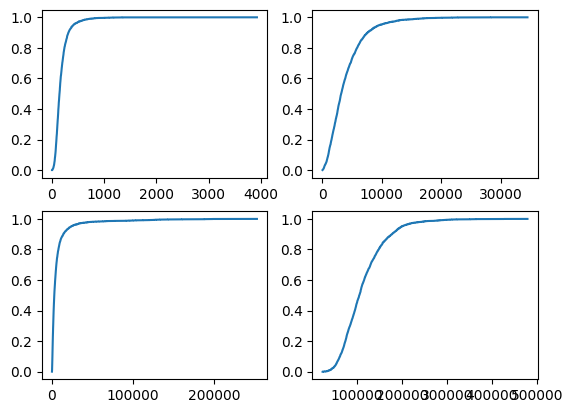

In [8]:
L = 2
fig, axs = plt.subplots(L, L)
for i in range(L):
    for j in range(L):
        gene = df.columns[i*L + j]
        gene_data = df[gene].sort_values()
        gene_data = gene_data.reset_index(drop=True)
        ecdf = sm.distributions.ECDF(gene_data)
        axs[i, j].step(ecdf.x, ecdf.y)
plt.show()

We notice that the gene reads span mulitple orders of magnitude. There are some outliers, as can be seen from the quantiles and from the curves above.

We visualize the distribution of a few cells and genes to get a feeling for the data, using violin plots.

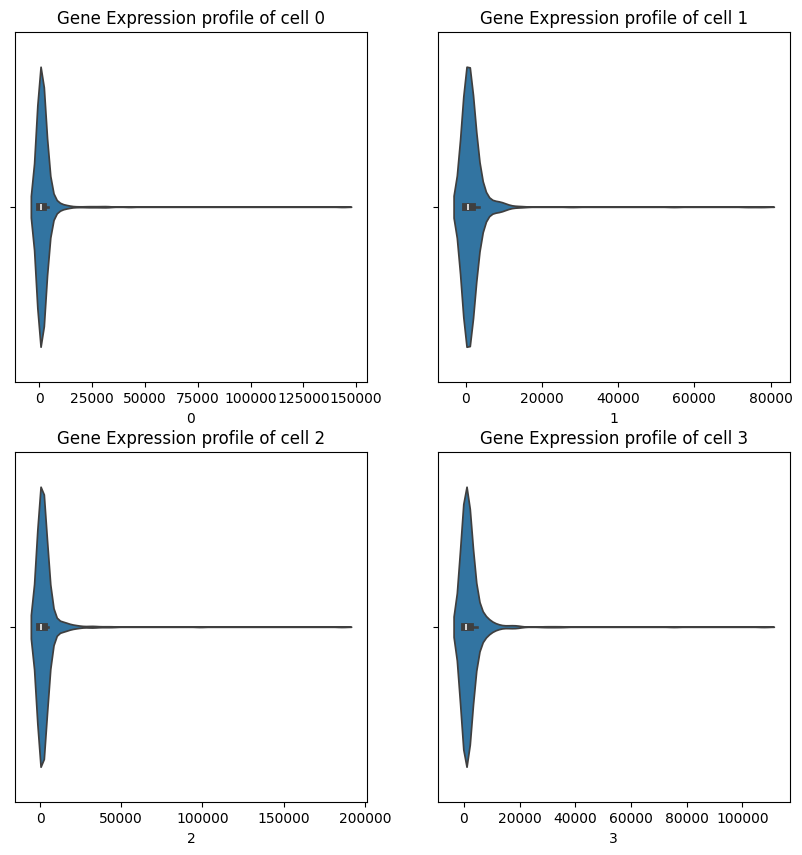

In [9]:
L = 2
fig, axs = plt.subplots(L, L, figsize=(10, 10))
for i in range(L):
    for j in range(L):
        sns.violinplot(x=df.iloc[i * L + j, :], ax=axs[i, j])
        axs[i, j].set_title('Gene Expression profile of cell {}'.format(i * L + j))

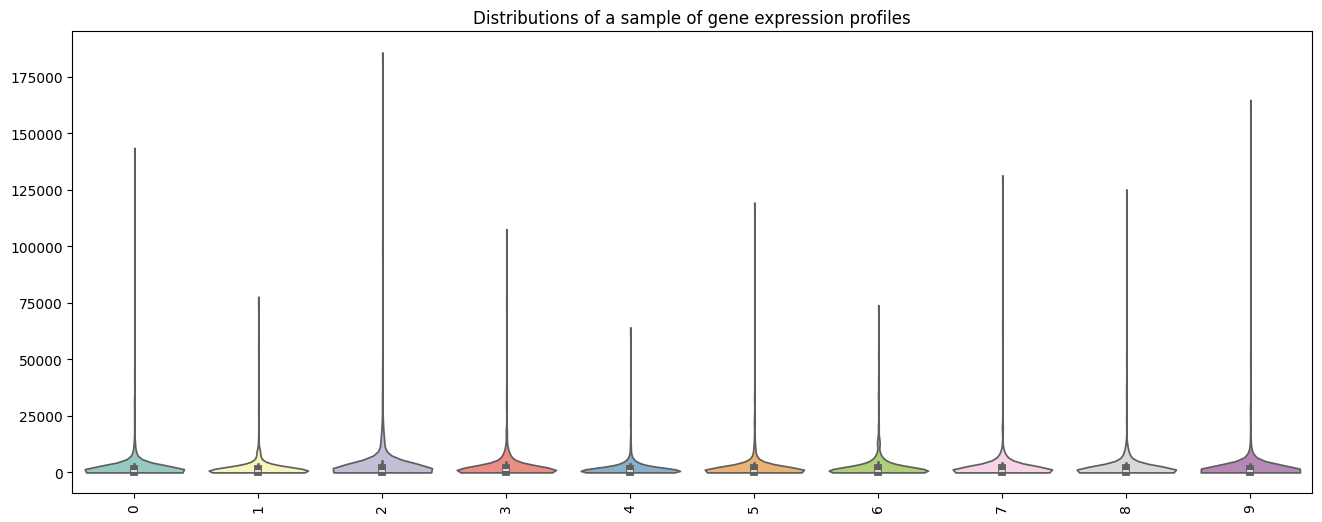

In [10]:
df_small = df.iloc[:10, :].T
plt.figure(figsize=(16, 6))
sns.violinplot(data=df_small, palette='Set3', cut=0)
plt.xticks(rotation=90)
plt.title("Distributions of a sample of gene expression profiles")
plt.show()

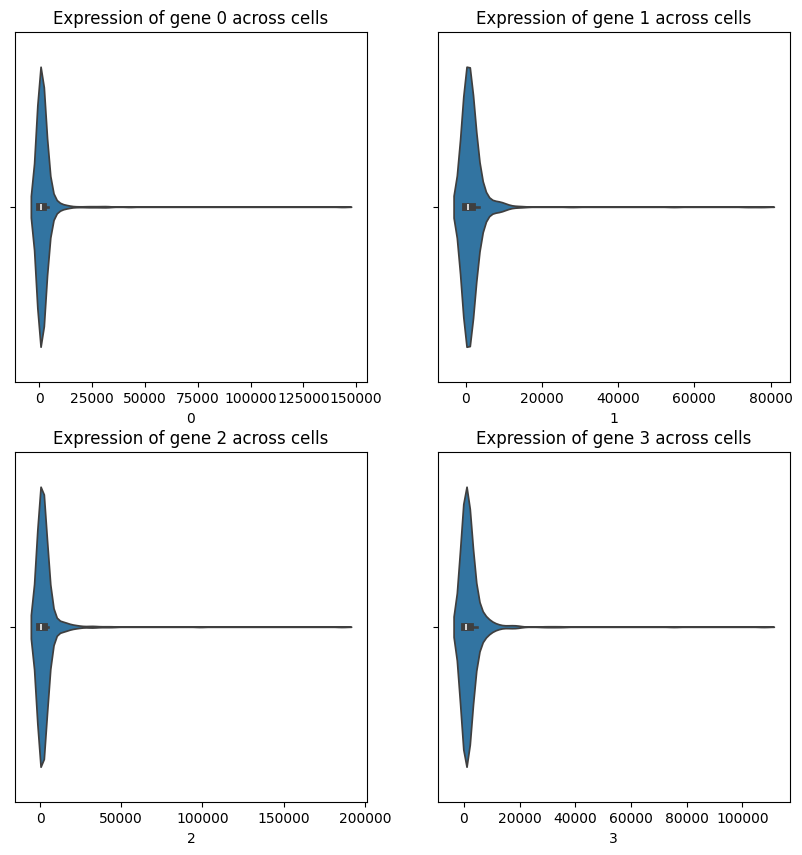

In [11]:
L = 2
fig, axs = plt.subplots(L, L, figsize=(10, 10))
for i in range(L):
    for j in range(L):
        sns.violinplot(x=df.iloc[i * L + j, :], ax=axs[i, j])
        axs[i, j].set_title('Expression of gene {} across cells'.format(i * L + j))

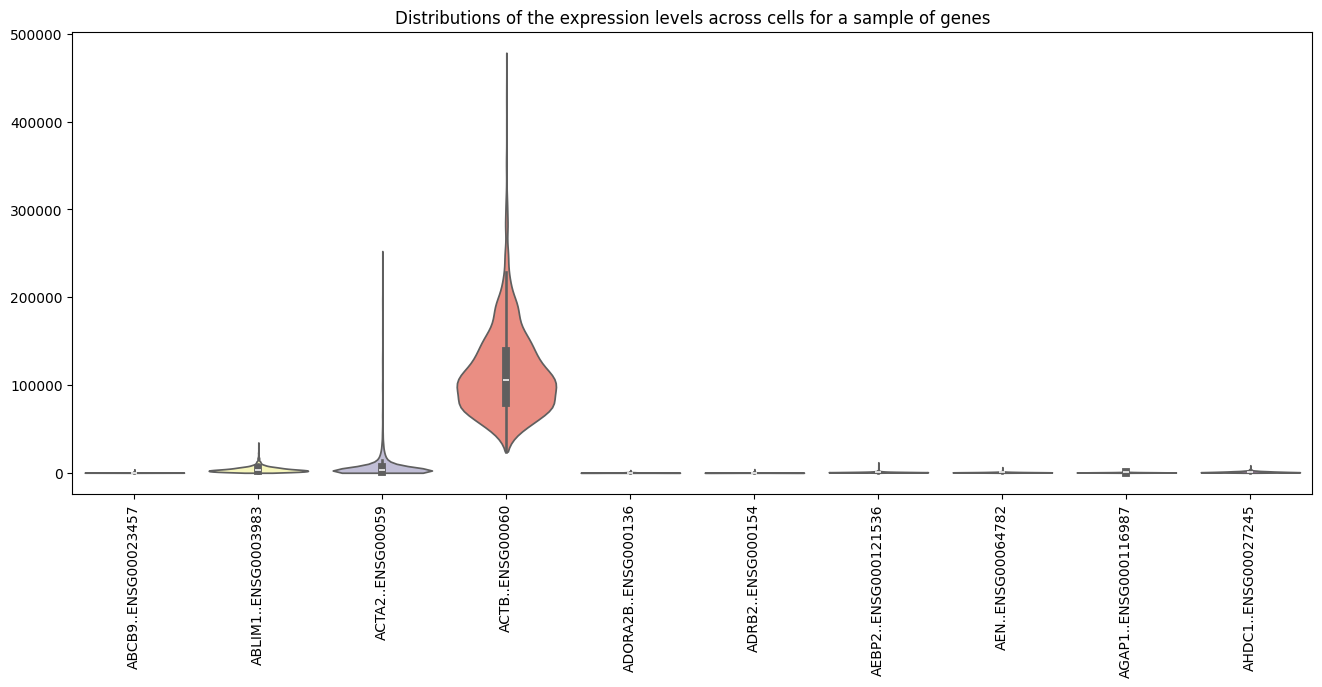

In [12]:
df_small = df.iloc[:, :10]
plt.figure(figsize=(16, 6))
sns.violinplot(data=df_small, palette='Set3', cut=0)
plt.xticks(rotation=90)
plt.title("Distributions of the expression levels across cells for a sample of genes")
plt.show()

We check the sparsity level of the gene expression profiles. With some single cell sequencing datasets, it happens that the examples are extremely sparse. This is important to take into account, both for computational efficiency and to correctly interpret statistics. In our case, however, it seems that the sparsity level is small:

In [13]:
print("sparsity level:", (df == 0).sum().sum() / df.size)

sparsity level: 0.02183073369763143


As noticed above, the distributions cover a very long range, spanning multiple orders of magnitude. This might be an indication that the data is more naturally handled in log scale. We proceed to log the data.

In [14]:
df = df + 1
df = df.apply(np.log)
df.head()

ABCB9..ENSG00023457  ABLIM1..ENSG0003983  ACTA2..ENSG00059  \
0             5.934447             7.215137          7.813017   
1             5.294532             8.588327          7.835805   
2             4.775048             7.569071          9.584294   
3             4.123045             8.642697          8.177915   
4             5.794467             7.000890          8.140747   

   ACTB..ENSG00060  ADORA2B..ENSG000136  ADRB2..ENSG000154  \
0        11.874808             5.079377           4.161014   
1        11.260971             3.028012           1.275277   
2        12.132652             4.569447           5.261996   
3        11.586603             4.475457           6.955230   
4        11.069254             3.967217           2.350546   

   AEBP2..ENSG000121536  AEN..ENSG00064782  AGAP1..ENSG000116987  \
0              6.853974           6.441707              5.844109   
1              7.664805           6.598498              5.959989   
2              6.643240           5.550670              5.483182   
3              6.550241           5.235063              5.573567   
4              6.561045           7.389280              6.712186   

   AHDC1..ENSG00027245  ...  ZBTB38..ENSG000253461  ZBTB7C..ENSG000201501  \
0             6.078646  ...               7.507344               5.581080   
1             7.079042  ...               6.270153               2.882507   
2             7.589402  ...               7.272697               5.108705   
3             6.606058  ...               7.667308               6.029641   
4             6.949722  ...               7.064357               5.220280   

   ZCCHC2..ENSG00054877  ZDHHC14..ENSG00079683  ZFP36L1..ENSG000677  \
0              5.781805               4.335412             9.054743   
1              5.436506               5.778419             8.771449   
2              5.445323               4.805102             9.451544   
3              6.460857               5.842396             8.990352   
4              6.694328               4.829257             7.209111   

   ZMAT3..ENSG00064393  ZMIZ1..ENSG00057178  ZMIZ2..ENSG00083637  \
0             3.806482             7.486781             8.579524   
1             3.625477             8.073540             8.075308   
2             4.321090             7.823210             8.295623   
3             4.374894             8.228719             7.898712   
4             5.474994             7.542669             7.733859   

   ZMYND8..ENSG00023613  ZNF561..ENSG00093134  
0              6.926901              6.711961  
1              7.432047              7.047872  
2              6.829752              5.973018  
3              7.063964              6.509368  
4              7.585093              6.175957  

[5 rows x 551 columns]

In [15]:
df.describe()

ABCB9..ENSG00023457  ABLIM1..ENSG0003983  ACTA2..ENSG00059  \
count          4211.000000          4211.000000       4211.000000   
mean              5.027813             7.974901          7.969045   
std               0.626356             0.858968          1.283715   
min               2.202930             3.426371          3.435540   
25%               4.646988             7.504782          7.108789   
50%               5.027859             8.061015          7.968105   
75%               5.418883             8.558827          8.782255   
max               8.273829            10.448972         12.439594   

       ACTB..ENSG00060  ADORA2B..ENSG000136  ADRB2..ENSG000154  \
count      4211.000000          4211.000000        4211.000000   
mean         11.565688             4.650616           3.932039   
std           0.404949             1.313455           1.525478   
min          10.094930             0.000000          -0.236694   
25%          11.281263             3.690667           2.808957   
50%          11.569894             4.824152           3.902163   
75%          11.844288             5.702702           5.045088   
max          13.078457             8.044607           8.338559   

       AEBP2..ENSG000121536  AEN..ENSG00064782  AGAP1..ENSG000116987  \
count           4211.000000        4211.000000           4211.000000   
mean               6.578123           6.240796              5.955885   
std                0.506659           0.544390              0.548099   
min                3.084302           4.079519              2.301865   
25%                6.254682           5.900068              5.625751   
50%                6.549512           6.262482              5.994350   
75%                6.874010           6.601142              6.328758   
max                9.387942           8.765176              7.976482   

       AHDC1..ENSG00027245  ...  ZBTB38..ENSG000253461  ZBTB7C..ENSG000201501  \
count          4211.000000  ...            4211.000000            4211.000000   
mean              6.785079  ...               7.302806               5.368857   
std               0.671384  ...               0.623959               1.578166   
min               4.077046  ...               3.781573              -0.385372   
25%               6.318749  ...               6.948576               4.438081   
50%               6.810597  ...               7.344228               5.576313   
75%               7.281827  ...               7.704253               6.496792   
max               9.055739  ...               9.378394               9.051503   

       ZCCHC2..ENSG00054877  ZDHHC14..ENSG00079683  ZFP36L1..ENSG000677  \
count           4211.000000            4211.000000          4211.000000   
mean               5.888605               5.255410             8.778089   
std                0.523837               0.762479             0.580441   
min                3.549658               0.000000             5.633546   
25%                5.563261               4.772332             8.415821   
50%                5.904590               5.247498             8.803912   
75%                6.226508               5.721994             9.161130   
max                8.283070               8.350040            10.528471   

       ZMAT3..ENSG00064393  ZMIZ1..ENSG00057178  ZMIZ2..ENSG00083637  \
count          4211.000000          4211.000000          4211.000000   
mean              4.571372             7.876275             7.872595   
std               0.760368             0.606623             0.459292   
min               0.336436             4.578454             5.829872   
25%               4.059743             7.517777             7.580225   
50%               4.606660             7.903264             7.879019   
75%               5.100909             8.259424             8.154116   
max               7.387480            10.165975            10.028752   

       ZMYND8..ENSG00023613  ZNF561..ENSG00093134  
count           4211.000000       

Now let's visualize the new data after applying the logarithm:

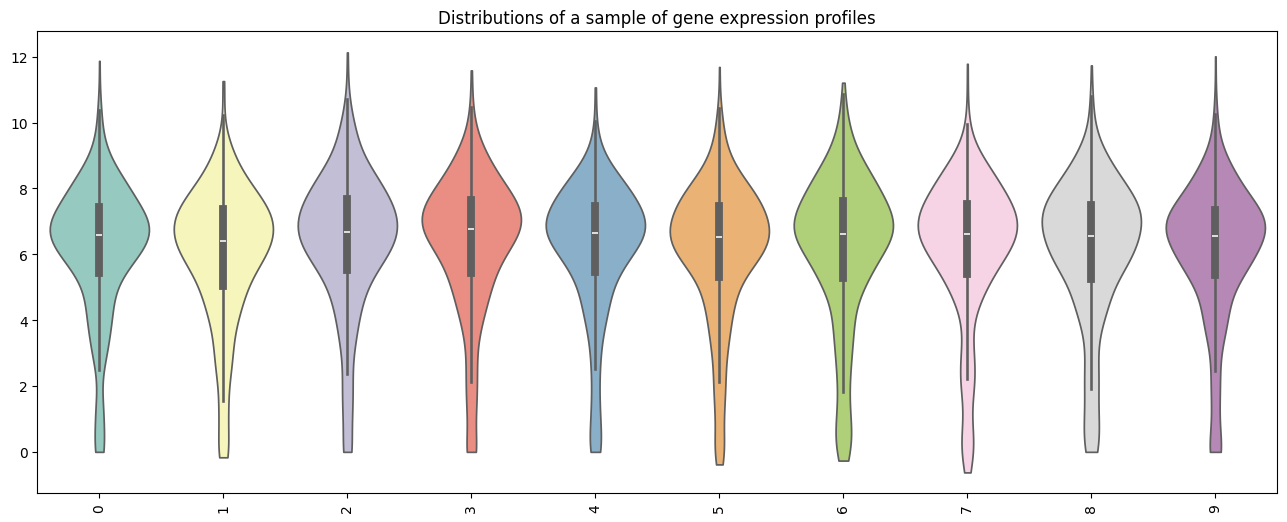

In [16]:
df_small = df.iloc[:10, :].T
plt.figure(figsize=(16, 6))
sns.violinplot(data=df_small, palette='Set3', cut=0)
plt.xticks(rotation=90)
plt.title("Distributions of a sample of gene expression profiles")
plt.show()

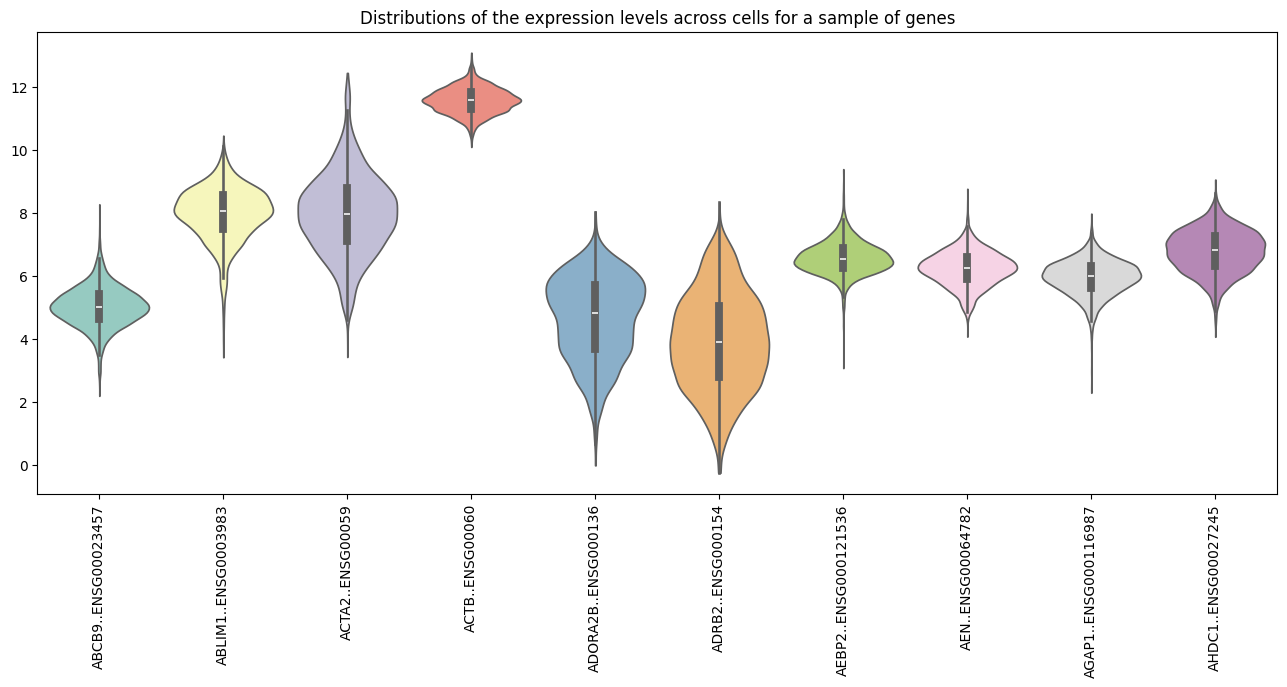

In [17]:
df_small = df.iloc[:, :10]
plt.figure(figsize=(16, 6))
sns.violinplot(data=df_small, palette='Set3', cut=0)
plt.xticks(rotation=90)
plt.title("Distributions of the expression levels across cells for a sample of genes")
plt.show()

To prepare for unsupervised and supervised machine learning algorithms, we also normalize the gene expressions, gene by gene. In fact, as we see from the graph above, different genes have different means and standard deviations, so algorithms (e.g., kmeans or logistic regression) risk focusing on some more than others, since they exhibit larger variation.

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
array = scaler.fit_transform(df)
df = pd.DataFrame(array, columns=df.columns)
df.head()

ABCB9..ENSG00023457  ABLIM1..ENSG0003983  ACTA2..ENSG00059  \
0             1.447646            -0.884613         -0.121559   
1             0.425878             0.714228         -0.103805   
2            -0.403597            -0.472518          1.258411   
3            -1.444666             0.777533          0.162726   
4             1.224136            -1.134066          0.133770   

   ACTB..ENSG00060  ADORA2B..ENSG000136  ADRB2..ENSG000154  \
0         0.763446             0.326477           0.150118   
1        -0.752572            -1.235518          -1.741801   
2         1.400254            -0.061806           0.871933   
3         0.051656            -0.133374           1.982035   
4        -1.226063            -0.520368          -1.036843   

   AEBP2..ENSG000121536  AEN..ENSG00064782  AGAP1..ENSG000116987  \
0              0.544515           0.369101             -0.203957   
1              2.145054           0.657148              0.007488   
2              0.128538          -1.267854             -0.862544   
3             -0.055037          -1.847666             -0.697616   
4             -0.033712           2.109920              1.380025   

   AHDC1..ENSG00027245  ...  ZBTB38..ENSG000253461  ZBTB7C..ENSG000201501  \
0            -1.052329  ...               0.327846               0.134490   
1             0.437898  ...              -1.655197              -1.575655   
2             1.198149  ...              -0.048260              -0.164864   
3            -0.266677  ...               0.584245               0.418754   
4             0.245258  ...              -0.382200              -0.094157   

   ZCCHC2..ENSG00054877  ZDHHC14..ENSG00079683  ZFP36L1..ENSG000677  \
0             -0.203906              -1.206731             0.476685   
1             -0.863156               0.686013            -0.011440   
2             -0.846323              -0.590653             1.160385   
3              1.092553               0.769930             0.365736   
4              1.538300              -0.558970            -2.703400   

   ZMAT3..ENSG00064393  ZMIZ1..ENSG00057178  ZMIZ2..ENSG00083637  \
0            -1.006067            -0.642145             1.539354   
1            -1.244144             0.325224             0.441411   
2            -0.329199            -0.087487             0.921154   
3            -0.258430             0.581062             0.056869   
4             1.188542            -0.550005            -0.302103   

   ZMYND8..ENSG00023613  ZNF561..ENSG00093134  
0             -0.178460              0.727020  
1              0.742282              1.510726  
2             -0.355537             -0.996989  
3              0.071368              0.254357  
4              1.021242             -0.523517  

[5 rows x 551 columns]

In [19]:
df.describe()

ABCB9..ENSG00023457  ABLIM1..ENSG0003983  ACTA2..ENSG00059  \
count         4.211000e+03         4.211000e+03      4.211000e+03   
mean          1.555736e-15        -4.758325e-16     -3.678421e-16   
std           1.000119e+00         1.000119e+00      1.000119e+00   
min          -4.510562e+00        -5.295972e+00     -3.531972e+00   
25%          -6.080725e-01        -5.473712e-01     -6.702104e-01   
50%           7.394250e-05         1.002653e-01     -7.327976e-04   
75%           6.244316e-01         6.798808e-01      6.335571e-01   
max           5.182997e+00         2.880625e+00      3.482923e+00   

       ACTB..ENSG00060  ADORA2B..ENSG000136  ADRB2..ENSG000154  \
count     4.211000e+03         4.211000e+03       4.211000e+03   
mean     -2.682885e-16        -5.239219e-16      -3.610927e-16   
std       1.000119e+00         1.000119e+00       1.000119e+00   
min      -3.632389e+00        -3.541172e+00      -2.733064e+00   
25%      -7.024539e-01        -7.309452e-01      -7.363043e-01   
50%       1.038946e-02         1.321378e-01      -1.958719e-02   
75%       6.880706e-01         8.011018e-01       7.297264e-01   
max       3.736147e+00         2.584326e+00       2.888960e+00   

       AEBP2..ENSG000121536  AEN..ENSG00064782  AGAP1..ENSG000116987  \
count          4.211000e+03       4.211000e+03          4.211000e+03   
mean           1.923578e-16      -5.264529e-16          2.902241e-16   
std            1.000119e+00       1.000119e+00          1.000119e+00   
min           -6.896626e+00      -3.970557e+00         -6.667505e+00   
25%           -6.384559e-01      -6.259623e-01         -6.023963e-01   
50%           -5.647691e-02       3.984025e-02          7.018777e-02   
75%            5.840663e-01       6.620046e-01          6.803826e-01   
max            5.546441e+00       4.637628e+00          3.686992e+00   

       AHDC1..ENSG00027245  ...  ZBTB38..ENSG000253461  ZBTB7C..ENSG000201501  \
count         4.211000e+03  ...           4.211000e+03           4.211000e+03   
mean          1.149085e-15  ...           4.302740e-17           1.147397e-16   
std           1.000119e+00  ...           1.000119e+00           1.000119e+00   
min          -4.033989e+00  ...          -5.644040e+00          -3.646584e+00   
25%          -6.946628e-01  ...          -5.677806e-01          -5.898535e-01   
50%           3.801168e-02  ...           6.639363e-02           1.314692e-01   
75%           7.399737e-01  ...           6.434628e-01           7.147972e-01   
max           3.382461e+00  ...           3.326874e+00           2.333775e+00   

       ZCCHC2..ENSG00054877  ZDHHC14..ENSG00079683  ZFP36L1..ENSG000677  \
count          4.211000e+03           4.211000e+03         4.211000e+03   
mean           4.049638e-16          -9.449155e-17         3.610927e-16   
std            1.000119e+00           1.000119e+00         1.000119e+00   
min           -4.465560e+00          -6.893345e+00        -5.418151e+00   
25%           -6.211531e-01          -6.336376e-01        -6.241986e-01   
50%            3.051905e-02          -1.037819e-02         4.449485e-02   
75%            6.451297e-01           6.120030e-01         6.599933e-01   
max            4.571553e+00           4.059123e+00         3.015966e+00   

       ZMAT3..ENSG00064393  ZMIZ1..ENSG00057178  ZMIZ2..ENSG00083637  \
count         4.211000e+03         4.211000e+03         4.211000e+03   
mean         -9.837246e-16         6.665029e-16         1.740501e-15   
std           1.000119e+00         1.000119e+00         1.000119e+00   
min          -5.570250e+00        -5.437008e+00        -4.448082e+00   
25%          -6.729505e-01        -5.910434e-01        -6.366437e-01   
50%           4.641426e-02         4.449540e-02         1.398821e-02   
75%           6.965039e-01         6.316853e-01         6.130188e-01   
max           3.704052e+00         3.774953e+00         4.695084e+00   

       ZMYND8..ENSG00023613  ZNF561..ENSG00093134  
count          4.211000e+03       

Data visualization after normalization:

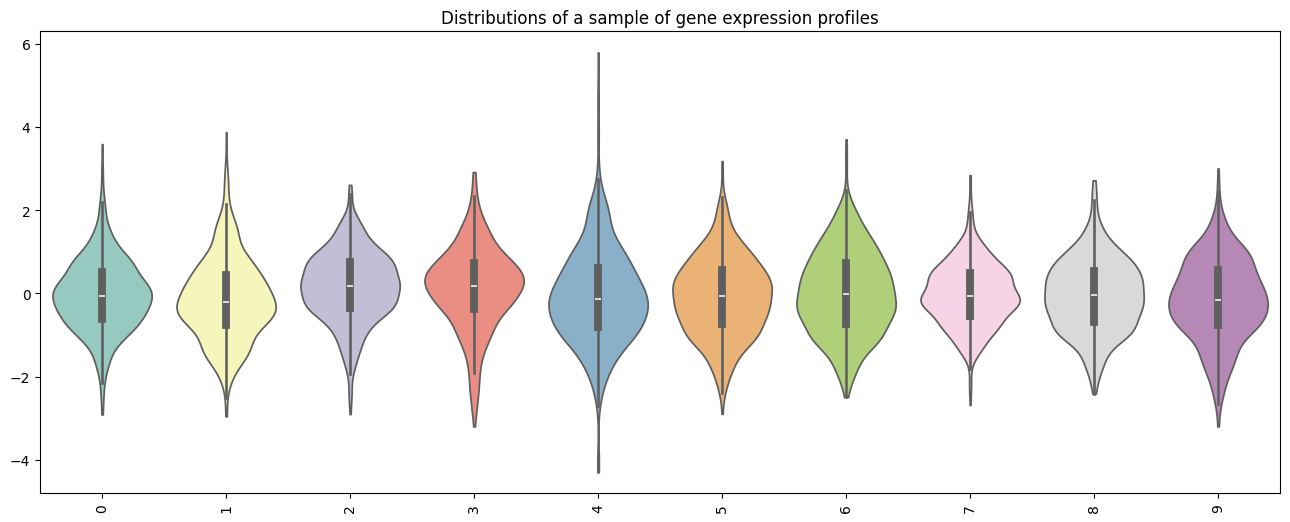

In [20]:
df_small = df.iloc[:10, :].T
plt.figure(figsize=(16, 6))
sns.violinplot(data=df_small, palette='Set3', cut=0)
plt.xticks(rotation=90)
plt.title("Distributions of a sample of gene expression profiles")
plt.show()

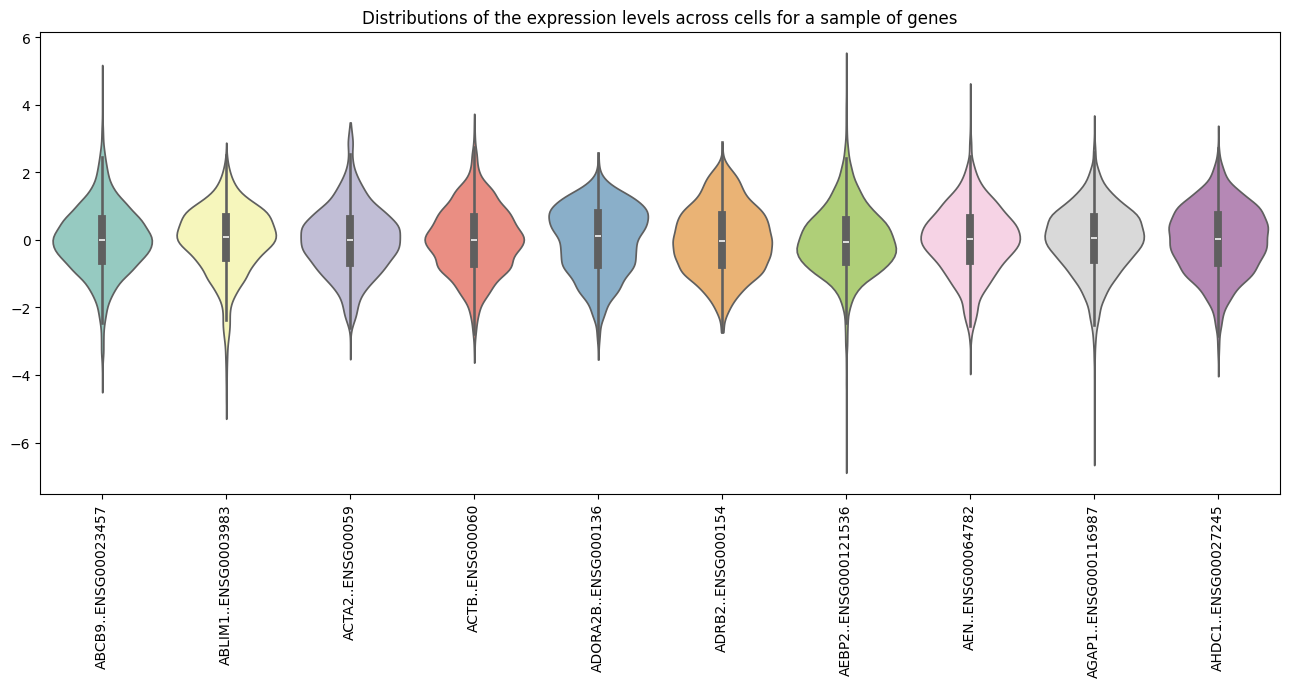

In [21]:
df_small = df.iloc[:, :10]
plt.figure(figsize=(16, 6))
sns.violinplot(data=df_small, palette='Set3', cut=0)
plt.xticks(rotation=90)
plt.title("Distributions of the expression levels across cells for a sample of genes")
plt.show()

## Dimensionality Reduction

In order to visualize the data, and to check whether any interesting patterns are visible, we use two dimensionality reduction techniques. 

First, we resort to an explainable and simple linear technique, PCA, to find a set of few orthogonal directions that explain most of the variance of the data. We can also inspect the principal components, which represent 'metagenes' along which our dataset exhibits large variance, and may turn out to be useful for classification as well.

Then, we employ a more powerful nonlinear dimensionality reduction technique, tSNE, which was designed specifically for data visualization, to get a more accurate depiction of the local structure of our data.

### PCA

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(df)
array_pca = pca.transform(df)
df_pca = pd.DataFrame(array_pca, columns=['PC1', 'PC2'])

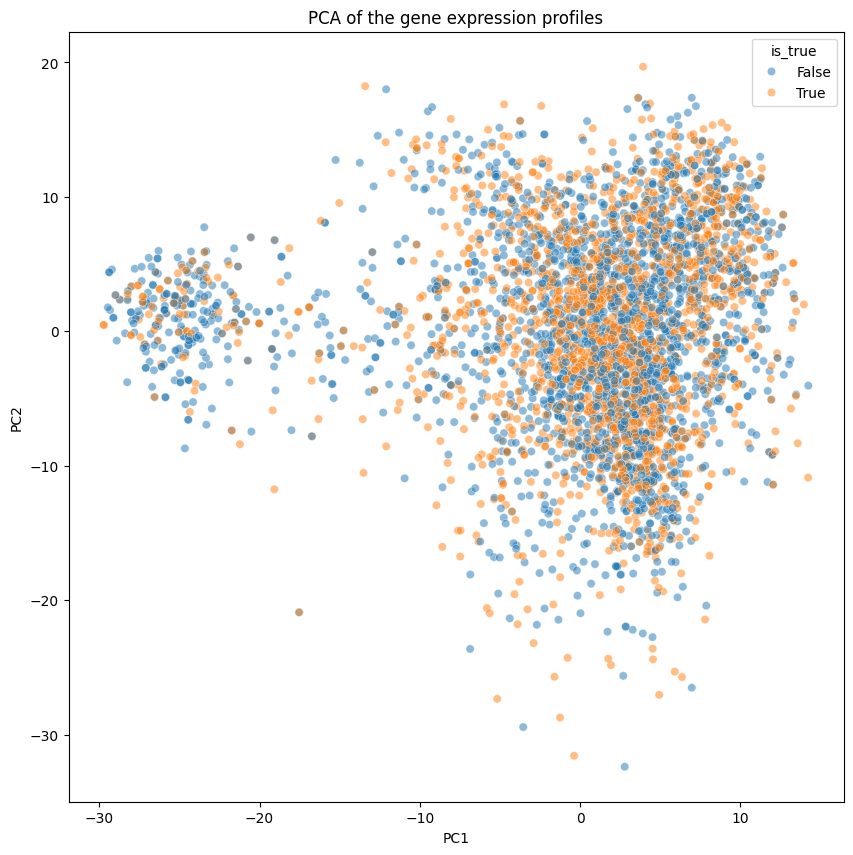

In [23]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', data=df_pca, hue=df_full['is_true'], alpha=0.5)
plt.title("PCA of the gene expression profiles")
plt.show()


In [24]:
array_reconstructed = pca.inverse_transform(array_pca)
mse = ((array - array_reconstructed) ** 2).mean()
print("MSE of the reconstruction:", mse)

MSE of the reconstruction: 0.7599185302386199


In [25]:
explained_variance = pca.explained_variance_ratio_.sum()
print("Explained variance:", explained_variance)

Explained variance: 0.2400814697613779


With only two directions, only 24% of the variance is explained. The reconstruction error is high (0.76, with data having features with standard deviation 1 and mean 0). We try to increase the number of principal components, and monitor how the explained variance increases.

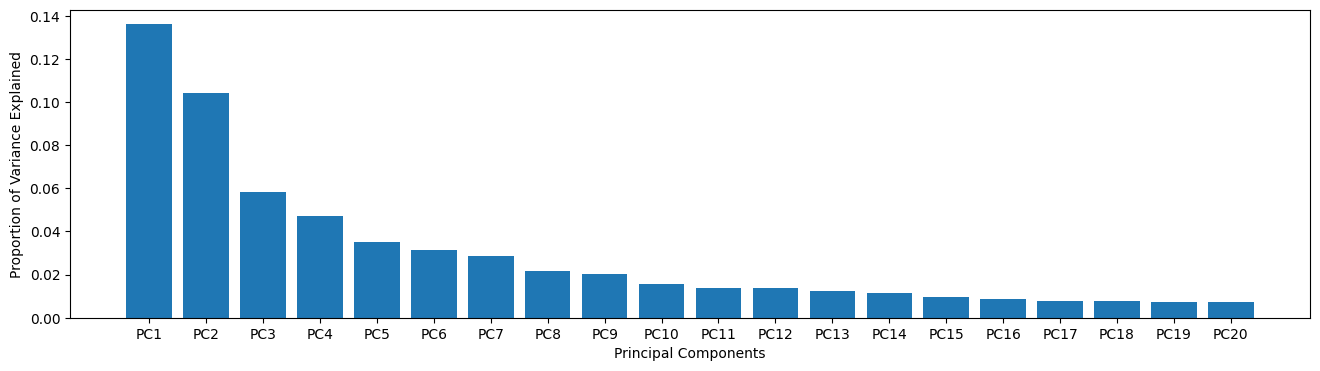

In [26]:
pca = PCA(n_components=551)
pca.fit(df)
array_pca = pca.transform(df)
var = pca.explained_variance_ratio_[0:20]
labels = ["PC"+str(i+1) for i in range(20)]
plt.figure(figsize=(16,4))
plt.bar(labels, var)
plt.xlabel('Principal Components')
plt.ylabel('Proportion of Variance Explained')
plt.show()

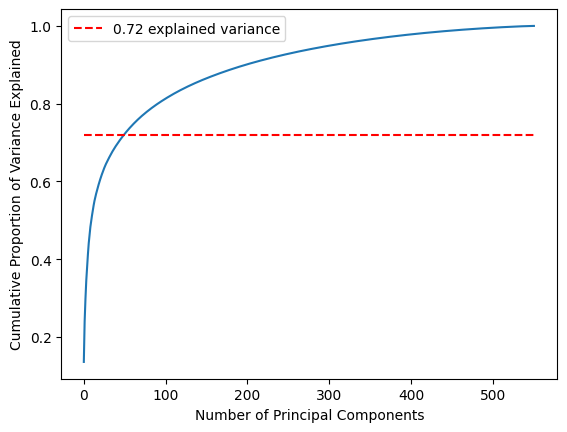

In [36]:
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_var)
plt.hlines(0.72, 0, 551, colors='r', linestyles='dashed', label='0.72 explained variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.legend()
plt.show()

In [38]:
np.argmax(cum_var > 0.72)  # hacky

49

As is often the case, most of the variance is explained using relatively few components. There seems to be an ellbow around 49 components. These plots will be useful in the classification part, using PCA to extract features from data.

### tSNE

As the results of tSNE are sensible to the choice of hyperparameters, and especially of perplexity, we try a few configurations in a grid and go for the hyperparameters that yield the most stable results.

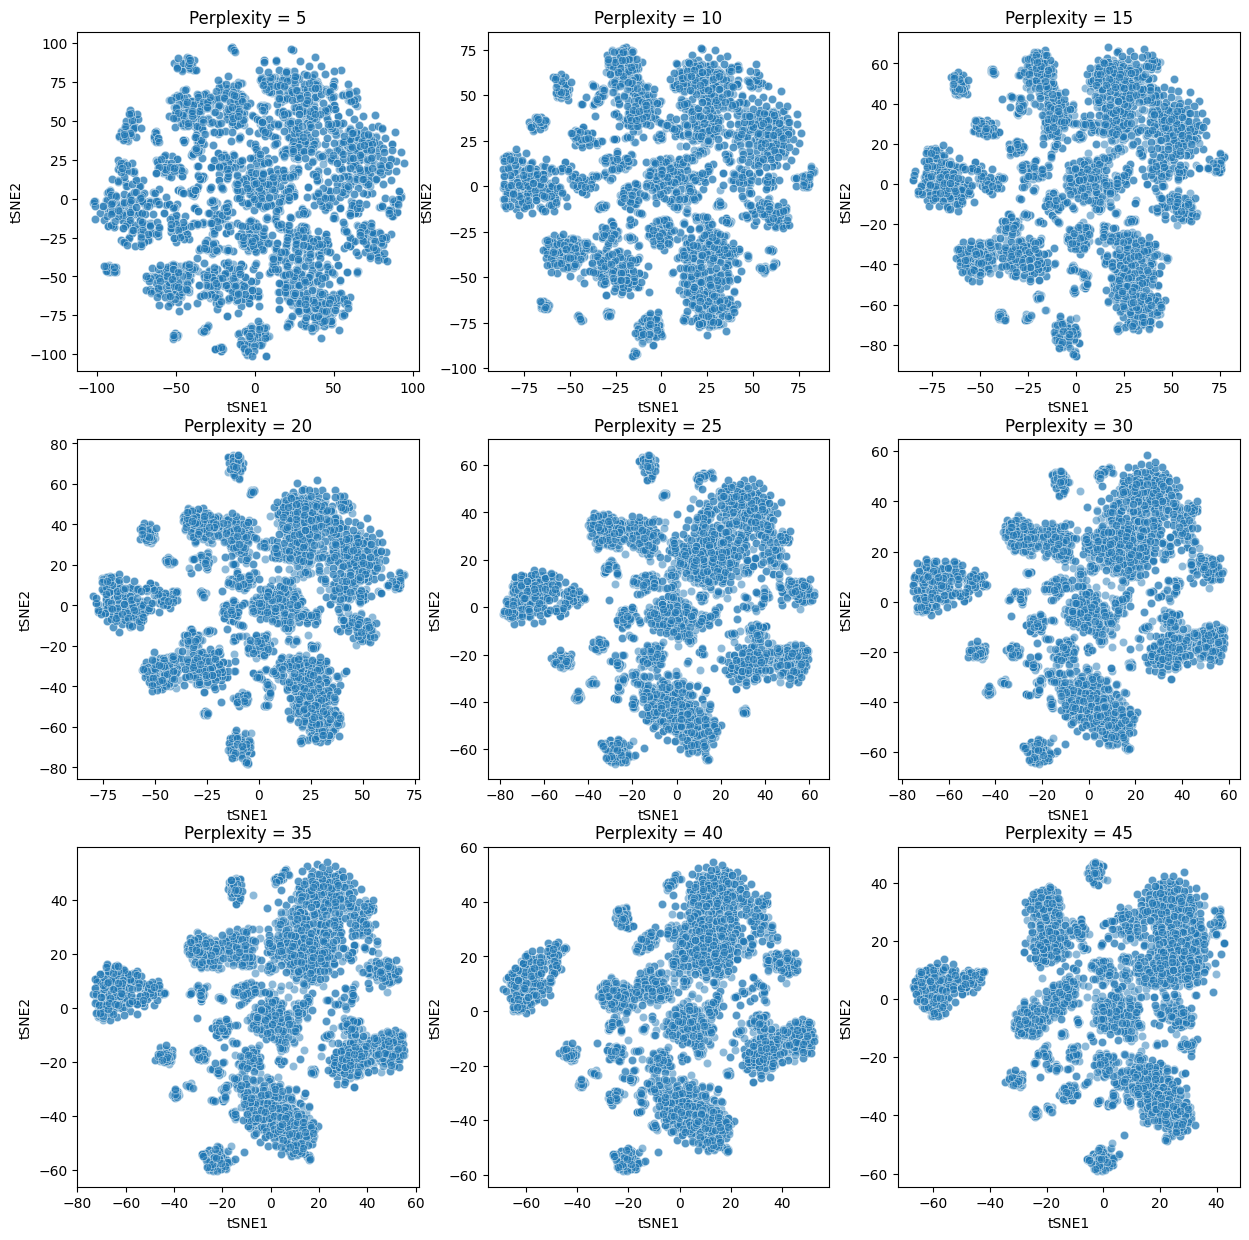

In [40]:
from sklearn.manifold import TSNE

L = 3
fig, axs = plt.subplots(L, L, figsize=(15, 15))
perplexities = [5, 10, 15, 20, 25, 30, 35, 40, 45]
for i in range(L):
    for j in range(L):
        perplexity = perplexities[i * L + j]
        tsne = TSNE(n_components=2, perplexity=perplexity, max_iter=1000)
        array_tsne = tsne.fit_transform(df)
        df_tsne = pd.DataFrame(array_tsne, columns=['tSNE1', 'tSNE2'])
        sns.scatterplot(x='tSNE1', y='tSNE2', data=df_tsne, alpha=0.5, ax=axs[i, j])
        axs[i, j].set_title('Perplexity = {}'.format(perplexity))

Results look crispier and more stable for values of the perplexity in the range 15-35. We go for 25.
Notice that some clusters seem to emerge. We will investigate further later, using clustering techniques, to see whether this is an artifact of dimensionality reduction or whether, even in the higher dimensional space, clusters emerge naturally.
Now, let's see whether any structure emerges by coloring points according to their labels - first functional vs non functional and then mutation type.

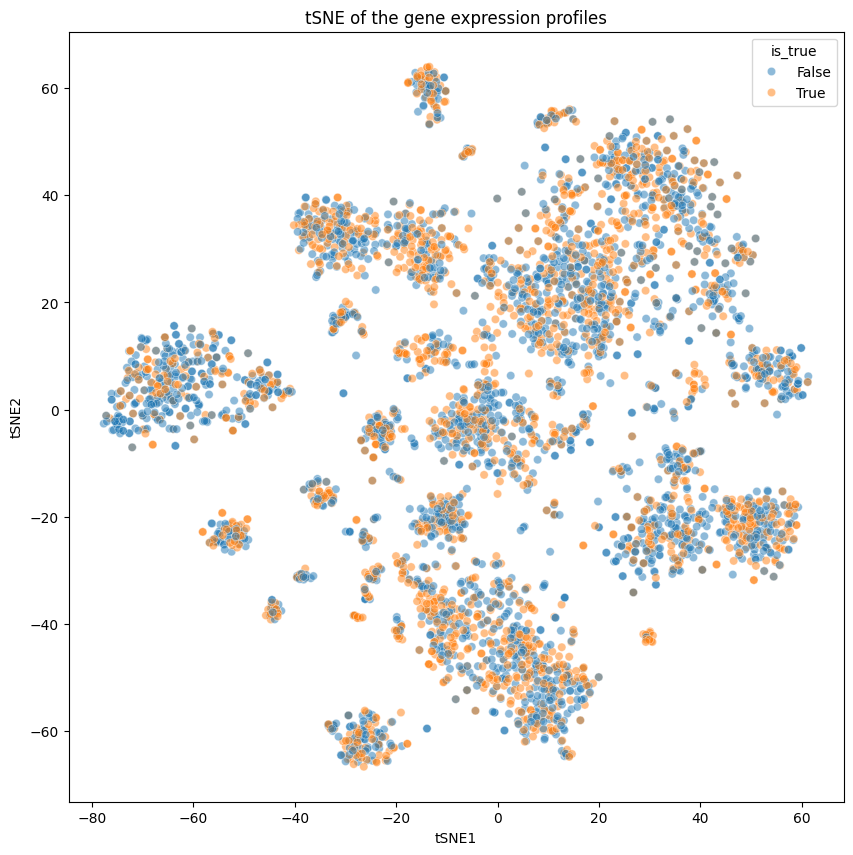

In [41]:
tsne = TSNE(n_components=2, perplexity=25, max_iter=1000)
array_tsne = tsne.fit_transform(df)
df_tsne = pd.DataFrame(array_tsne, columns=['tSNE1', 'tSNE2'])

plt.figure(figsize=(10, 10))
sns.scatterplot(x='tSNE1', y='tSNE2', data=df_tsne, hue=df_full['is_true'], alpha=0.5)
plt.title("tSNE of the gene expression profiles")
plt.show()

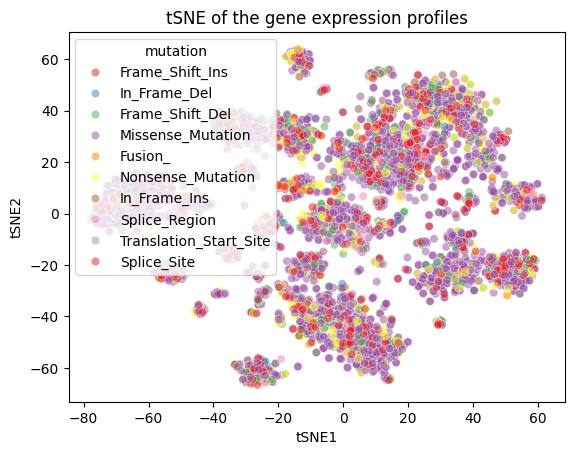

In [42]:
#plt.figure(figsize=(10, 10))
sns.scatterplot(x='tSNE1', y='tSNE2', data=df_tsne, hue=df_full['mutation'], alpha=0.5, palette='Set1')
plt.title("tSNE of the gene expression profiles")
plt.show()

## Clustering

In [43]:
gene_columns = [col for col in df.columns if col not in ['is_true', 'mutation', 'Variant_Classification']]
X = df[gene_columns].to_numpy()

In [44]:
X.shape

(4211, 551)

In [ ]:
# for visualization later

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

tsne = TSNE(n_components=2, perplexity=25, max_iter=1000)
array_tsne = tsne.fit_transform(df[gene_columns])
df_tsne = pd.DataFrame(array_tsne, columns=['tSNE1', 'tSNE2'])

We want to perform clustering on our data. Gene expression profiles live in a 500-dimensional space. Since clustering is entirely based on a notion of distance in the data space, it's important that the used metric be meaningful. However, because of the well known phenomenon of the curse of dimensionality, distances tend to lose meaning as the dimension of the ambient space increases (there are counter intuitive phenomena like concentration of volume on boundaries, quasi-orthogonality of random vectors and many other well known examples happening). For this reason, we carry out clustering on dimensionally reduced data, using PCA. 
For the number of components, we use the one we highlighted as ellbow, since it strikes a good trade off between information retain and dimensionality.

In [45]:
pca = PCA(n_components=50)
pca.fit(X)
X_pca = pca.transform(X)

To choose the number of clusters, which must be provided as input to Kmeans, we use two indicators: Silhouette score and inertia.

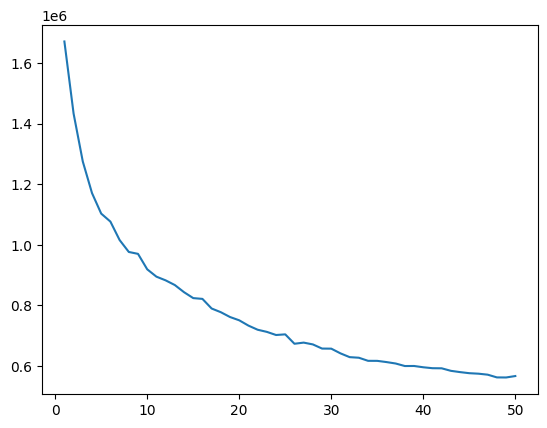

In [48]:
from sklearn.cluster import KMeans
inertia = []
for k in range(1, 51):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 51), inertia)

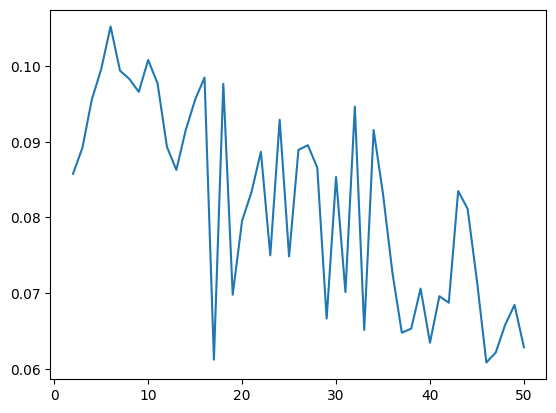

In [49]:
# silhouette score
from sklearn.metrics import silhouette_score

silhouette = []
for k in range(2, 51):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_pca)
    silhouette.append(silhouette_score(X, kmeans.labels_))
plt.plot(range(2, 51), silhouette)

In [54]:
2 + np.argmax(silhouette)

6

The number of clusters maximizing the Silhouette score is k = 6. The inertia gives little indication, as no clear elbow is visible. We go with k = 6.

In [55]:
k = 6
kmeans = KMeans(n_clusters=k)
kmeans.fit(X_pca)
df_tsne['cluster'] = kmeans.labels_

The Silhouette score is low so the quality of the clusters is not optimal. Since the value is near 0, we expect to have poorly clustered points

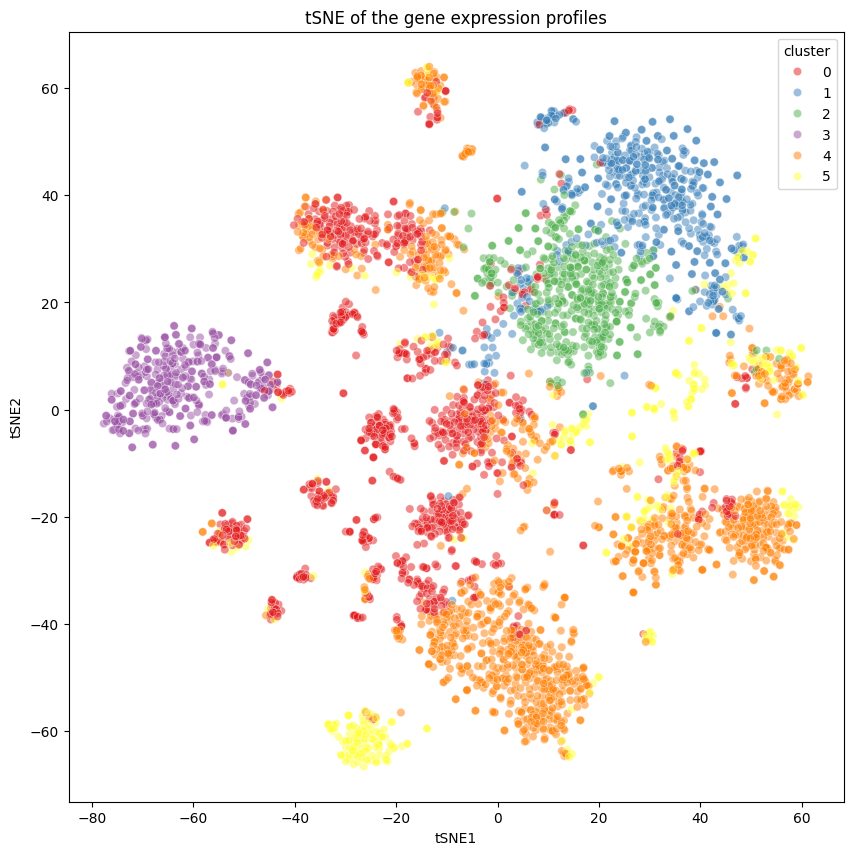

In [56]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='tSNE1', y='tSNE2', data=df_tsne, hue=df_tsne['cluster'], alpha=0.5, palette='Set1')
plt.title("tSNE of the gene expression profiles")
plt.show()

## Correlation for feature selection

To find the most promising genes to consider for classification, we calculate the correlation of the labels with each single gene. We use the point biserial correlation coefficient, since we are dealing with a continuous and a binary variable. This is a special case of the Pearson correlation coefficient.


In [57]:
csv_file = 'data/TCGA_labels.csv'
df = pd.read_csv(csv_file)
df.head()

Variant_Classification  ABCB9..ENSG00023457  \
0  A129Vfs*20_TCGA-66-2785_Frame_Shift_Ins_17:g.7...           376.831000   
1  A138_P142del_TCGA-25-2393_In_Frame_Del_17:g.75...           198.244448   
2  A138Cfs*27_TCGA-55-6980_Frame_Shift_Del_17:g.7...           117.516000   
3  A138Cfs*27_TCGA-55-6980_Frame_Shift_Del_17:g.7...            60.747000   
4  A138Cfs*27_TCGA-D8-A13Y_Frame_Shift_Del_17:g.7...           327.477000   

   ABLIM1..ENSG0003983  ACTA2..ENSG00059  ACTB..ENSG00060  \
0           1358.86000       2471.580000     143602.00000   
1           5367.62179       2528.570328      77726.97678   
2           1936.34000      14533.700000     185841.00000   
3           5667.60000       3560.420000     107645.00000   
4           1096.61000       3430.480000      64166.60000   

   ADORA2B..ENSG000136  ADRB2..ENSG000154  AEBP2..ENSG000121536  \
0           159.674000          63.136500            946.639000   
1            19.656121           2.579692           2130.976296   
2            95.490700         191.866000            766.578000   
3            86.834700        1047.620000            698.413000   
4            51.837300           9.491300            706.010000   

   AEN..ENSG00064782  AGAP1..ENSG000116987  ...  ZCCHC2..ENSG00054877  \
0         626.477000            344.195000  ...            323.344000   
1         732.991931            386.605718  ...            228.638412   
2         256.410000            239.611000  ...            230.672000   
3         186.741000            262.372000  ...            638.609000   
4        1617.540000            821.366000  ...            806.811000   

   ZDHHC14..ENSG00079683  ZFP36L1..ENSG000677  ZMAT3..ENSG00064393  \
0              75.356400          8558.040000            43.991900   
1             322.247574          6446.509718            36.542642   
2             121.132000         12726.800000            74.270600   
3             343.604000          8024.280000            78.431400   
4             124.118000          1350.690000           237.649000   

   ZMIZ1..ENSG00057178  ZMIZ2..ENSG00083637  ZMYND8..ENSG00023613  \
0          1783.300000          5320.570000           1018.330000   
1          3207.438557          3213.116903           1688.261865   
2          2496.910000          4005.300000            923.961000   
3          3746.030000          2692.810000           1168.070000   
4          1885.860000          2283.400000           1967.630000   

   ZNF561..ENSG00093134  is_true         mutation  
0            821.181000     True  Frame_Shift_Ins  
1           1149.407697     True     In_Frame_Del  
2            391.689000     True  Frame_Shift_Del  
3            670.402000     True  Frame_Shift_Del  
4            480.043000     True  Frame_Shift_Del  

[5 rows x 554 columns]

In [59]:
def log_and_normalize(df: pd.DataFrame) -> pd.DataFrame:
    # all columns but 'is_true', 'mutation', and 'Variant_Classification'
    features = df.drop(columns=["is_true", "mutation", "Variant_Classification"])
    # log-transform and normalize the features
    features = features.apply(lambda x: np.log(1 + x))
    features = (features - features.mean()) / features.std()
    # add back the non-numeric columns
    features = pd.concat(
        [features, df[["mutation", "Variant_Classification", "is_true"]]], axis=1
    )
    return features

df = log_and_normalize(df)

In [60]:
df.head()

ABCB9..ENSG00023457  ABLIM1..ENSG0003983  ACTA2..ENSG00059  \
0             1.447474            -0.884508         -0.121544   
1             0.425827             0.714143         -0.103793   
2            -0.403549            -0.472462          1.258262   
3            -1.444494             0.777441          0.162707   
4             1.223990            -1.133931          0.133754   

   ACTB..ENSG00060  ADORA2B..ENSG000136  ADRB2..ENSG000154  \
0         0.763355             0.326438           0.150100   
1        -0.752483            -1.235371          -1.741594   
2         1.400088            -0.061798           0.871830   
3         0.051650            -0.133358           1.981800   
4        -1.225917            -0.520306          -1.036720   

   AEBP2..ENSG000121536  AEN..ENSG00064782  AGAP1..ENSG000116987  \
0              0.544450           0.369058             -0.203933   
1              2.144800           0.657070              0.007487   
2              0.128522          -1.267703             -0.862442   
3             -0.055030          -1.847446             -0.697533   
4             -0.033708           2.109670              1.379861   

   AHDC1..ENSG00027245  ...  ZDHHC14..ENSG00079683  ZFP36L1..ENSG000677  \
0            -1.052204  ...              -1.206587             0.476628   
1             0.437846  ...               0.685931            -0.011439   
2             1.198007  ...              -0.590583             1.160248   
3            -0.266645  ...               0.769839             0.365693   
4             0.245229  ...              -0.558904            -2.703079   

   ZMAT3..ENSG00064393  ZMIZ1..ENSG00057178  ZMIZ2..ENSG00083637  \
0            -1.005947            -0.642069             1.539171   
1            -1.243997             0.325185             0.441359   
2            -0.329160            -0.087477             0.921045   
3            -0.258399             0.580993             0.056862   
4             1.188400            -0.549939            -0.302067   

   ZMYND8..ENSG00023613  ZNF561..ENSG00093134         mutation  \
0             -0.178439              0.726934  Frame_Shift_Ins   
1              0.742193              1.510547     In_Frame_Del   
2             -0.355494             -0.996870  Frame_Shift_Del   
3              0.071359              0.254326  Frame_Shift_Del   
4              1.021121             -0.523455  Frame_Shift_Del   

                              Variant_Classification  is_true  
0  A129Vfs*20_TCGA-66-2785_Frame_Shift_Ins_17:g.7...     True  
1  A138_P142del_TCGA-25-2393_In_Frame_Del_17:g.75...     True  
2  A138Cfs*27_TCGA-55-6980_Frame_Shift_Del_17:g.7...     True  
3  A138Cfs*27_TCGA-55-6980_Frame_Shift_Del_17:g.7...     True  
4  A138Cfs*27_TCGA-D8-A13Y_Frame_Shift_Del_17:g.7...     True  

[5 rows x 554 columns]

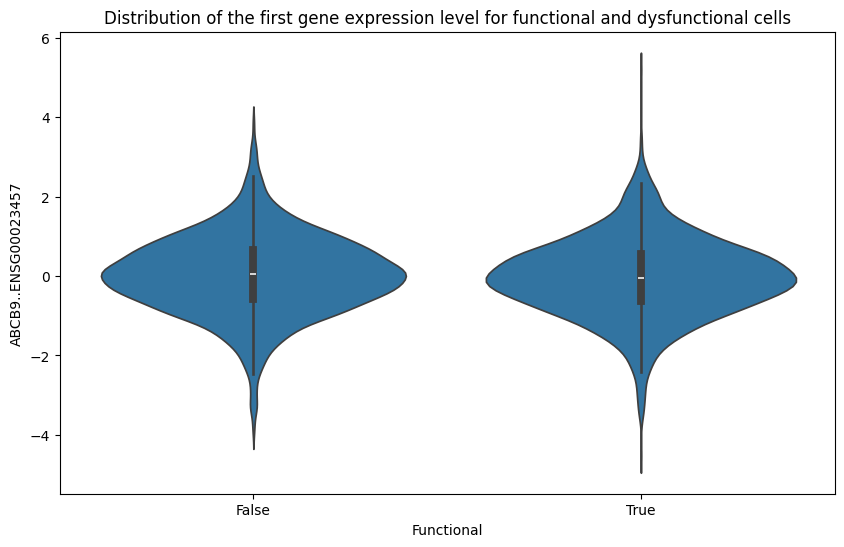

In [63]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='is_true', y=df.columns[0], data=df)
plt.xlabel('Functional')
plt.title("Distribution of the first gene expression level for functional and dysfunctional cells")
plt.show()

### Correlations of genes with labels

#### Functional vs Dysfunctional

In [64]:
from scipy import stats

correlations = {}
for gene in df.columns:
    if gene in ['is_true', 'mutation', 'Variant_Classification']:
        continue
    a = df['is_true'].to_numpy().astype(np.float64)
    b = df[gene].to_numpy().astype(np.float64)
    corr, pval = stats.pointbiserialr(a, b)
    correlations[gene] = corr

In [66]:
corrs = list(correlations.values())
corrs = np.array(corrs)
np.abs(corrs).mean(), np.abs(corrs).std(), np.abs(corrs).max()

(0.027919123954705125, 0.01954913018439728, 0.08834416504312281)

Genes are not very correlated with the labels. Most of them would essentially provide noise for the classifier to see through and it's probably going to be better to remove them. Let's visualize the correlations as a curve.

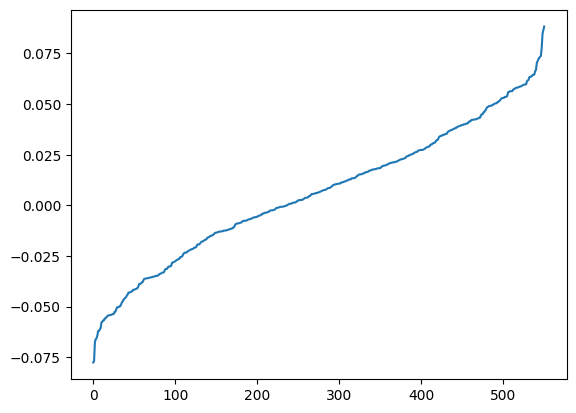

In [ ]:
corrs.sort()
plt.plot(corrs)

In [67]:
# save genes in order of absolute correlation for later use

import json

sorted_correlations = sorted(correlations.items(), key=lambda x: np.abs(x[1]), reverse=True)
good_genes = [corr[0] for corr in sorted_correlations]
with open('good_genes_tf.txt', 'w') as f:
    json.dump(good_genes, f)

#### Mutation type

In [ ]:
from scipy import stats

correlations = {}
for gene in df.columns:
    if gene in ['is_true', 'mutation', 'Variant_Classification']:
        continue
    a = (df['mutation'] == 'Missense_Mutation').to_numpy().astype(np.float64)
    b = df[gene].to_numpy().astype(np.float64)
    corr, pval = stats.pointbiserialr(a, b)
    correlations[gene] = corr

In [ ]:
corrs = list(correlations.values())
corrs = np.array(corrs)
np.abs(corrs).mean()
np.abs(corrs).std()
np.abs(corrs).max()

0.09154977907792622

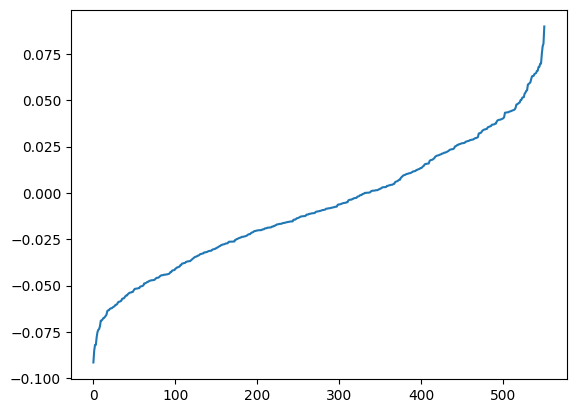

In [ ]:
corrs.sort()
plt.plot(corrs)

In [ ]:
import json

sorted_correlations = sorted(correlations.items(), key=lambda x: np.abs(x[1]), reverse=True)
good_genes = [corr[0] for corr in sorted_correlations]
with open('good_genes_missense.txt', 'w') as f:
    json.dump(good_genes, f)

# Classification

In [71]:
from copy import deepcopy


df = deepcopy(df_full)
df = df.drop(columns=['is_true', 'mutation', 'Variant_Classification'])
df = log_and_normalize(df)
y = df_full['mutation']

We check the proportions of each class

In [72]:
y.value_counts() / len(y)

mutation
Missense_Mutation         0.642840
Nonsense_Mutation         0.129898
Frame_Shift_Del           0.093090
Splice_Site               0.066018
Frame_Shift_Ins           0.028734
In_Frame_Del              0.018048
Splice_Region             0.011874
Fusion_                   0.005937
In_Frame_Ins              0.003325
Translation_Start_Site    0.000237
Name: count, dtype: float64

Since non-missense mutations aren't well represented, we group them under a single label.

In [73]:
y = y.apply(lambda x: 1 if x == 'Missense_Mutation' else 0)
y.value_counts() / len(y)

mutation
1    0.64284
0    0.35716
Name: count, dtype: float64

We split the dataset into three subsets: train set to train our models, validation set to tune the hyperparameters and test set to assess the results.

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

We now proceed to fit classifiers to our data. We focus here and comment on the task of predicting missense vs non-missense mutation on the TCGA dataset: the results for the other 3 data-task combinations are similar and can be found in the Appendix.

To solve this task, we refrain from using deep learning and instead resort to classical supervised learning methods that are simpler and less prone to overfitting. This choice is motivated by the scarcity of available labeled samples.

We use k-fold cross validation to obtain statistically robust estimates of the validation error of different hyperparameter combinations.

## Random forest

In [79]:
from classification import hyperparameter_search, plot_hyperparameter_search_results
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7, 10, 15, 20],
    'bootstrap': [True, False],
}
best_model, best_params, best_score, all_results = hyperparameter_search(model, X_train, y_train, X_val, y_val,
                                                                         param_grid, search_type='grid', cv=3,
                                                                         verbose=2)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/fedezara/Desktop/Uni/ML_Lab/ML-lab/.env/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[CV] END ......bootstrap=True, max_depth=3, n_estimators=100; total time=   0.9s
[CV] END ......bootstrap=True, max_depth=3, n_estimators=100; total time=   1.0s
[CV] END ......bootstrap=True, max_depth=3, n_estimators=100; total time=   1.0s
[CV] END ......bootstrap=True, max_depth=3, n_estimators=200; total time=   2.0s
[CV] END ......bootstrap=True, max_depth=5, n_estimators=100; total time=   1.7s
[CV] END ......bootstrap=True, max_depth=3, n_estimators=200; total time=   2.2s
[CV] END ......bootstrap=True, max_depth=3, n_estimators=200; total time=   2.2s
[CV] END ......bootstrap=True, max_depth=5, n_estimators=100; total time=   1.7s
[CV] END ......bootstrap=True, max_depth=5, n_estimators=100; total time=   1.7s
[CV] END ......bootstrap=True, max_depth=5, n_estimators=200; total time=   3.4s
[CV] END ......bootstrap=True, max_depth=5, n_estimators=200; total time=   3.3s
[CV] END ......bootstrap=True, max_depth=7, n_estimators=100; total time=   2.3s
[CV] END ......bootstrap=Tru

In [80]:
best_score, best_params

(0.6374702448506858, {'bootstrap': True, 'max_depth': 3, 'n_estimators': 100})

In [81]:
all_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.944050      0.002095         0.006691        0.000289   
1        2.119778      0.113329         0.011196        0.001514   
2        1.701781      0.039845         0.007754        0.000657   
3        3.352598      0.014125         0.017225        0.005087   
4        2.195985      0.083558         0.010570        0.000109   
5        4.316012      0.121449         0.015152        0.001435   
6        3.004821      0.133886         0.014984        0.003769   
7        6.220438      0.090637         0.023012        0.002087   
8        4.194359      0.094336         0.015986        0.000267   
9        8.391120      0.045164         0.036372        0.007899   
10       4.808971      0.093022         0.016921        0.001846   
11      10.300905      0.328983         0.046419        0.015163   
12       1.816695      0.144765         0.008075        0.001287   
13       3.610183      0.191006         0.017109        0.007282   
14       3.079734      0.103045         0.013391        0.001045   
15       5.646223      0.062186         0.019088        0.004333   
16       3.804721      0.070347         0.011369        0.001509   
17       7.499158      0.059104         0.022138        0.003130   
18       5.063129      0.074582         0.012530        0.000085   
19      10.031743      0.100523         0.028881        0.003178   
20       7.038615      0.239637         0.021251        0.001091   
21      14.531496      0.182539         0.100267        0.091074   
22       8.693597      0.156225         0.038521        0.013196   
23      15.372774      0.615014         0.034115        0.003216   

    param_bootstrap  param_max_depth  param_n_estimators  \
0              True                3                 100   
1              True                3                 200   
2              True                5                 100   
3              True                5                 200   
4              True                7                 100   
5              True                7                 200   
6              True               10                 100   
7              True               10                 200   
8              True               15                 100   
9              True               15                 200   
10             True               20                 100   
11             True               20                 200   
12            False                3                 100   
13            False                3                 200   
14            False                5                 100   
15            False                5                 200   
16            False                7                 100   
17            False                7                 200   
18            False               10                 100   
19            False               10                 200   
20            False               15                 100   
21            False               15                 200   
22            False               20                 100   
23            False               20                 200   

                                               params  split0_test_score  \
0   {'bootstrap': True, 'max_depth': 3, 'n_estimat...           0.637578   
1   {'bootstrap': True, 'max_depth': 3, 'n_estimat...           0.637578   
2   {'bootstrap': True, 'max_depth': 5, 'n_estimat...           0.637578   
3   {'bootstrap': True, 'max_depth': 5, 'n_estimat...           0.637578   
4   {'bootstrap': True, 'max_depth': 7, 'n_estimat...           0.637578   
5   {'bootstrap': True, 'max_depth': 7, 'n_estimat...           0.637578   
6   {'bootstrap': True, 'max_depth': 10, 'n_estima...           0.635797   
7   {'bootstrap': True, 'max_depth': 10, 'n_estima...           0.636687   
8   {'bootstrap': True, 'max_depth': 15, 'n_estima...           0.626892   
9   {'bootstrap': True, 'max_depth': 15, '

In [82]:
from sklearn.metrics import accuracy_score

y_pred = best_model.predict(X_test)
accuracy_score(y_test, y_pred)
print(f"Test accuracy of best model: {accuracy_score(y_test, y_pred):.2f}")

Test accuracy of best model: 0.68


The accuracy of the best performing random forest on the validation set is very bad: sligthly above the fraction of the dataset that belongs to the most represented class. However, the performance on the training set is good: the models are overfitting.
Later on, to regularize training, we will try to select and to extract features, to reduce noise in the training data and hopefully improve performance.

To visualize the impact of different parameters on the validation performance, we use histograms.

param_n_estimators
100    0.630245
200    0.630146
Name: mean_test_score, dtype: float64
param_max_depth
3     0.637470
5     0.637470
7     0.637025
10    0.631606
15    0.619877
20    0.617724
Name: mean_test_score, dtype: float64
param_bootstrap
False    0.629131
True     0.631259
Name: mean_test_score, dtype: float64


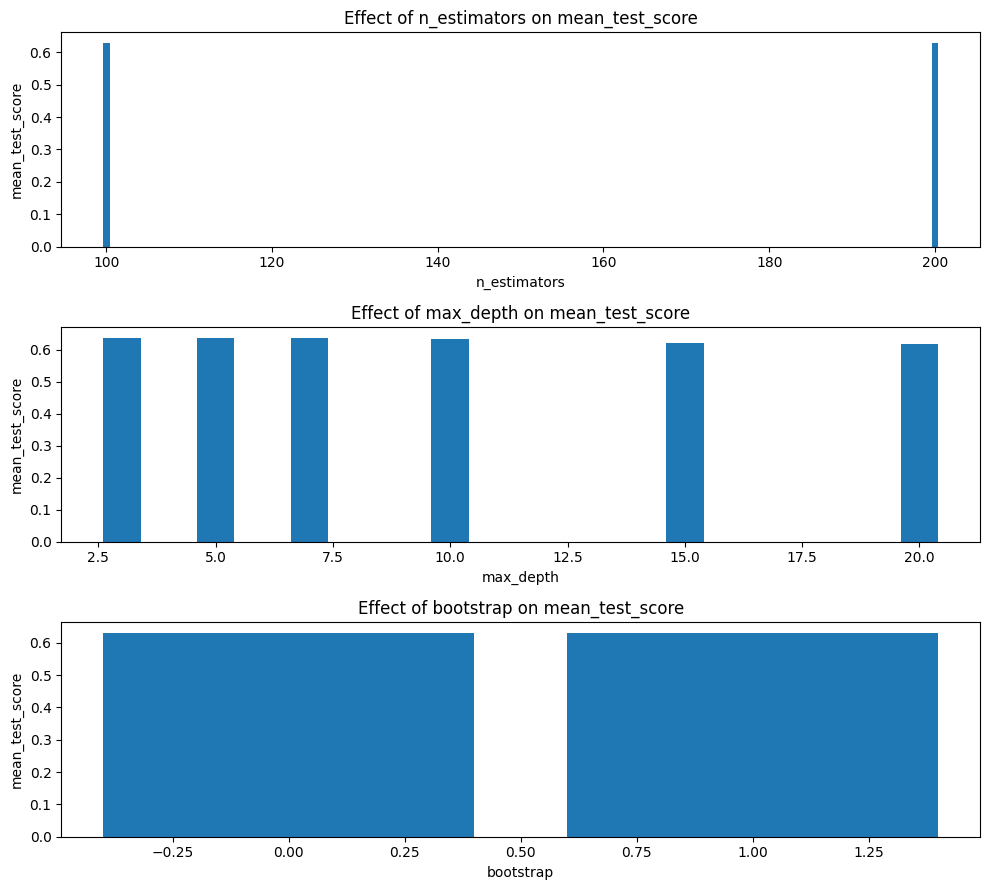

In [83]:
plot_hyperparameter_search_results(all_results, param_grid)

We use a confusion matrix to understand the types of errors our best performing random forest is making.

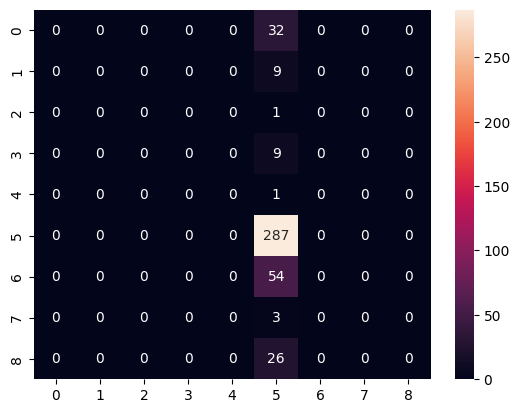

In [84]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

## Other models

In [87]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=10000)
param_grid = {
    "penalty": ['l2', 'l1', 'elasticnet'],
    "C": [0.001, 0.005, 0.01, 0.1],

}
best_model, best_params, best_score, all_results = hyperparameter_search(model, X_train, y_train, X_val, y_val,
                                                                         param_grid, search_type='grid', cv=3,
                                                                         verbose=2)

y_pred = best_model.predict(X_test)
accuracy_score(y_test, y_pred)
print(f"Test accuracy of best model: {accuracy_score(y_test, y_pred):.2f}")

plot_hyperparameter_search_results(all_results, param_grid)
plt.show()

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/fedezara/Desktop/Uni/ML_Lab/ML-lab/.env/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .........................C=0.01, penalty=elasticnet; total time=   0.0s
[CV] END .........................C=0.01, penalty=elasticnet; total time=   0.0s
[CV] END .........................C=0.01, penalty=elasticnet; total time=   0.0s


KeyboardInterrupt: 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [1, 3, 5, 10, 15],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
best_model, best_params, best_score, all_results = hyperparameter_search(model, X_train, y_train, X_val, y_val,
                                                                         param_grid, search_type='grid', cv=3,
                                                                         verbose=2)

y_pred = best_model.predict(X_test)
accuracy_score(y_test, y_pred)
print(f"Test accuracy of best model: {accuracy_score(y_test, y_pred):.2f}")

plot_hyperparameter_search_results(all_results, param_grid)
plt.show()

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [ ]:
from sklearn.svm import SVC

model = SVC()
param_grid = {
    'C': [0.001, 0.005, 0.01, 0.1],
    'gamma': ['scale', 'auto'],
    "kernel": ['rbf', 'poly', 'sigmoid', 'linear'],
}
best_model, best_params, best_score, all_results = hyperparameter_search(model, X_train, y_train, X_val, y_val,
                                                                         param_grid, search_type='grid', cv=3,
                                                                         verbose=2)

y_pred = best_model.predict(X_test)
accuracy_score(y_test, y_pred)
print(f"Test accuracy of best model: {accuracy_score(y_test, y_pred):.2f}")

plot_hyperparameter_search_results(all_results, param_grid)
plt.show()

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()



## Feature Selection using correlations

Import previously computed features sorted by correletion with the labels

In [ ]:
import json
with open('good_genes_missense.txt') as f:
    ordered_genes = json.load(f)

In [ ]:
N_values = [10, 25, 50, 75, 100, 125, 150, 200, 300]
val_scores = []
train_scores = []
for N in N_values:
    good_genes = ordered_genes[:N]
    X_train_good = X_train[good_genes]
    X_val_good = X_val[good_genes]
    model = RandomForestClassifier(n_estimators=200, max_depth=5)  # TODO: choose classifier and hyperparams
    model.fit(X_train_good, y_train)
    val_scores.append(model.score(X_val_good, y_val))
    train_scores.append(model.score(X_train_good, y_train))

In [ ]:
plt.plot(N_values, val_scores, label='Validation')
plt.plot(N_values, train_scores, label='Train')
plt.xlabel('Number of genes')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs number of genes selected')
plt.show()

## Feature Extraction using PCA

In [ ]:
N_values = [10, 25, 50, 75, 100, 125, 150, 200, 300]
val_scores = []
train_scores = []
for N in N_values:
    pca = PCA(n_components=N)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_val_pca = pca.transform(X_val)
    model = RandomForestClassifier(n_estimators=200, max_depth=5)  # TODO: choose classifier and hyperparams
    model.fit(X_train_pca, y_train)
    val_scores.append(model.score(X_val_pca, y_val))
    train_scores.append(model.score(X_train_pca, y_train))

In [ ]:
plt.plot(N_values, val_scores, label='Validation')
plt.plot(N_values, train_scores, label='Train')
plt.xlabel('Number of PCA components')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs number of PCA components')
plt.show()

# Conclusions

From our analysis, it emerged that the data is too noisy to classify any of the two tasks with accuracy meaningfully better than what obtained by always outputting the most frequent label. This is in line with what was found in the paper. Our models learn, but they overfit the training set and achieve poor generalization performance.
Interestingly, although on an absolute scale the accuracy of our classifiers is not great, we did observe an improvement through both feature selection using correlation analysis and feature extraction through PCA. This is probably due to the regularizing effect of these methods, which remove some of the least informative features, thus reducing noise and mitigating overfitting.

# Appendix

# TODO: copy paste code cells from the classification part and execute them on the other 3 task-dataset combinations